In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [3]:
os.chdir('/content/drive/MyDrive')

# **EEG Brain Signal Classification**

Implement LSTM and EEGNet models to predict the label of each samples.

In [4]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt

# Import the packages you need here
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses

In [5]:
data = np.load('data.npz')
label = np.load('label.npz')

In [6]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [7]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [8]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [9]:
n_channels = X_train.shape[1]
time_points = X_train.shape[2]
input_shape = (n_channels, time_points)

## Model Implementation Part

### LSTM

In [10]:
# Build your model here:

model1 = models.Sequential()

model1.add(layers.LSTM(1000, input_shape=input_shape, return_sequences=False))
model1.add(layers.Dense(6, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4804000   
                                                                 
 dense (Dense)               (None, 6)                 6006      
                                                                 
Total params: 4,810,006
Trainable params: 4,810,006
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model1.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [12]:
n_epochs = 20
history1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=n_epochs)

Epoch 1/20
19/19 [==============================] - 8s 43ms/step - loss: 1.0496 - accuracy: 0.5646 - val_loss: 0.6195 - val_accuracy: 0.7697
Epoch 2/20
19/19 [==============================] - 0s 14ms/step - loss: 0.2432 - accuracy: 0.9305 - val_loss: 0.4301 - val_accuracy: 0.8026
Epoch 3/20
19/19 [==============================] - 0s 14ms/step - loss: 0.0361 - accuracy: 0.9983 - val_loss: 0.4234 - val_accuracy: 0.8487
Epoch 4/20
19/19 [==============================] - 0s 14ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3872 - val_accuracy: 0.8553
Epoch 5/20
19/19 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3656 - val_accuracy: 0.8618
Epoch 6/20
19/19 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3721 - val_accuracy: 0.8684
Epoch 7/20
19/19 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3752 - val_accuracy: 0.8618
Epoch 8/20
19

In [34]:
train_loss1, train_acc1 = model1.evaluate(X_train, Y_train, verbose=0)
val_loss1, val_acc1 = model1.evaluate(X_val, Y_val, verbose=0)
print("Train Accuracy:", train_acc1)
print("Val Accuracy:", val_acc1)

Train Accuracy: 1.0
Val Accuracy: 0.8684210777282715


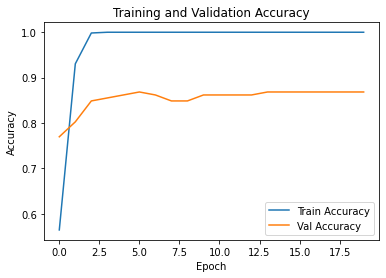

In [13]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

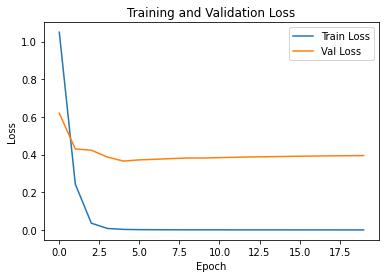

In [14]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [15]:
output1 = model1.predict(X_test)
output1 = np.argmax(output1, axis=1).reshape(-1, 1)
assert(output1.shape == (190, 1))
np.savetxt('lstm_output.csv', output1, delimiter=",")

6/6 [==============================] - 0s 7ms/step


### EEGNet

In [24]:
# Build your model here:

from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans = 64, Samples = 128, 
           kernLength = 64, dropoutRate = 0.5, norm_rate = 0.25, 
           F1 = 8, D = 2, F2 = 16):
    
    input     = layers.Input(shape = (Chans, Samples, 1))
    
    block1    = layers.Conv2D(F1, (1, kernLength), padding = 'same', input_shape = (Chans, Samples, 1), use_bias = False)(input)
    block1    = layers.BatchNormalization()(block1)
    block1    = layers.DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D, depthwise_constraint = max_norm(1.))(block1)
    block1    = layers.BatchNormalization()(block1)
    block1    = layers.Activation('elu')(block1)
    block1    = layers.AveragePooling2D((1, 4))(block1)
    block1    = layers.Dropout(dropoutRate)(block1)
    
    block2    = layers.SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
    block2    = layers.BatchNormalization()(block2)
    block2    = layers.Activation('elu')(block2)
    block2    = layers.AveragePooling2D((1, 8))(block2)
    block2    = layers.Dropout(dropoutRate)(block2)
    
    flatten   = layers.Flatten(name = 'flatten')(block2)
    dense     = layers.Dense(nb_classes, name = 'dense', kernel_constraint = max_norm(norm_rate))(flatten)
    output    = layers.Activation('softmax', name = 'softmax')(dense)
    
    return models.Model(inputs=input, outputs=output)

model2 = EEGNet(6, 22, 200)

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 22, 200, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 200, 8)        512       
                                                                 
 batch_normalization_9 (Batc  (None, 22, 200, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 200, 16)       352       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 200, 16)       64        
 chNormalization)                                                
                                                           

In [25]:
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model2.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [26]:
n_epochs = 100
history2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=n_epochs)

Epoch 1/100
19/19 [==============================] - 1s 18ms/step - loss: 1.7445 - accuracy: 0.2831 - val_loss: 1.7107 - val_accuracy: 0.5329
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 1.5045 - accuracy: 0.6242 - val_loss: 1.5715 - val_accuracy: 0.7368
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 1.2502 - accuracy: 0.7285 - val_loss: 1.4084 - val_accuracy: 0.8092
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 1.0545 - accuracy: 0.7914 - val_loss: 1.2692 - val_accuracy: 0.8355
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 0.9382 - accuracy: 0.8543 - val_loss: 1.1588 - val_accuracy: 0.8553
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.8505 - accuracy: 0.8609 - val_loss: 1.0884 - val_accuracy: 0.9013
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.8238 - accuracy: 0.8675 - val_loss: 1.0315 - val_accuracy: 0.9013
Epoch 8/100


In [35]:
train_loss2, train_acc2 = model2.evaluate(X_train, Y_train, verbose=0)
val_loss2, val_acc2 = model2.evaluate(X_val, Y_val, verbose=0)
print("Train Accuracy:", train_acc2)
print("Val Accuracy:", val_acc2)

Train Accuracy: 0.9900662302970886
Val Accuracy: 0.9868420958518982


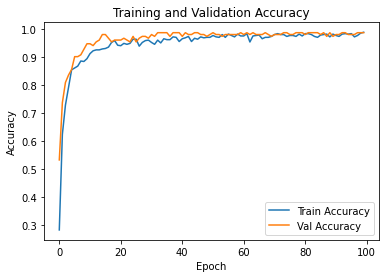

In [27]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

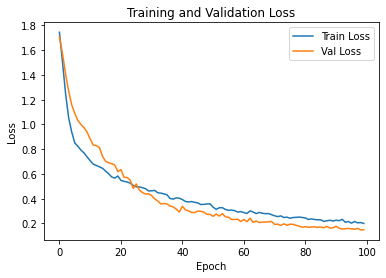

In [28]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [29]:
output2 = model2.predict(X_test)
output2 = np.argmax(output2, axis=1).reshape(-1, 1)
assert(output2.shape == (190, 1))
np.savetxt('eegnet_output.csv', output2, delimiter=",")

6/6 [==============================] - 0s 8ms/step
